In [1]:
%matplotlib inline

from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import Network
from pyIHACRES.Network import StreamNode, DamNode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
net = Network.load_network("../pyIHACRES/config/network.yml", first_node=406214)

In [3]:
network = net.network

In [4]:
# top_level_nodes = {k: node for k, node in network.items() if len(node.prev_node) == 0}
# top_level_nodes

In [5]:
system_outlets = {k: node for k, node in network.items() if node.next_node is None}
system_outlets

{406265: <pyIHACRES.Network.StreamNode.StreamNode at 0xd5354e0>}

In [6]:
climate_data = pd.read_csv("climate_subset.csv", index_col=0, comment='#', dayfirst=True, parse_dates=True)
np_data = np.array(np.rec.fromrecords(climate_data.values))
np_names = climate_data.dtypes.index.tolist()
np_data.dtype.names = tuple([name.encode('UTF8') for name in np_names])

dt_index = pd.to_datetime(climate_data.index)

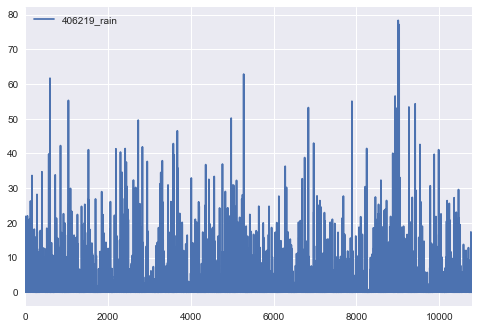

In [7]:
climate_data['406219_rain'].reset_index().plot()

In [8]:
climate_data = np.array(np.rec.fromrecords(climate_data.values))
climate_data.dtype.names = tuple([name.encode('UTF8') for name in np_names])

In [9]:
# mung extraction data for dev purposes

# Create array col names based on climate data
ext_names = np_names[:]
for idx, en in enumerate(ext_names):
    en = en.replace("rain", "irrig").replace("evap", "other")
    ext_names[idx] = en

In [10]:
# Munging dam release data for development purposes
# dam_release = pd.read_csv("policy_sw_int.csv", index_col=0, usecols=["Date", "Daily Dam Release (ML)"], parse_dates=True)

# The above is dam release from policy model for a previous run
# It is in a weekly time step, so we mung it back to daily, and output it into a file `sw_dam_ext.csv`
# dam_release.resample('1D').pad().to_csv("sw_dam_ext.csv")

# The above file is then manually combined with other synthetic sw data
# and read in below.

In [11]:
# Synthetic model data
dam_ext = pd.read_csv("sw_dam_ext.csv", index_col=0)
synthetic_dam_ext = dam_ext['Daily Dam Release (ML)'].tolist()

In [12]:
# Create synthetic extraction data (all zero)
ext_data = np.zeros_like(np_data)
ext_data.dtype.names = tuple([name.encode('UTF8') for name in ext_names])

In [13]:
historic_dam_ext = pd.read_csv("historic_releases_subset.csv")

In [14]:
# Assign synthetic data to extraction dataset
# ext_data['406000_irrig'] = synthetic_dam_ext

# Assign historic extraction data to extraction dataset
ext_data['406000_irrig'] = historic_dam_ext.iloc[:, 1].values

In [15]:
# Setting all dam extractions to 0.0
# ext_data['406000_irrig'] = 0.0  # historic_dam_ext['Dam Release (ML)']
# ext_data['406000_other'] = 0.0

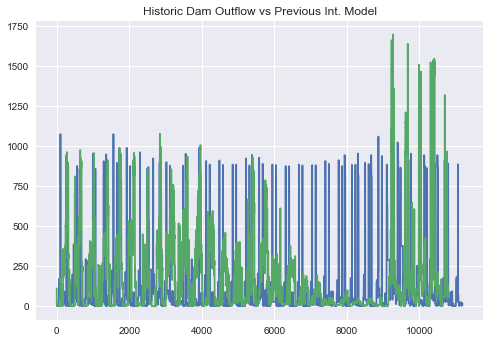

In [16]:
plt.plot(synthetic_dam_ext)
plt.plot(historic_dam_ext['Dam Release (ML/Day)'])
plt.title("Historic Dam Outflow vs Previous Int. Model")
plt.show()

In [17]:
# historic dam levels
hist_dam_levels = pd.read_csv('historic_dam_level_subset.csv', index_col=0, dayfirst=True, parse_dates=True)

# historic dam data is shorter than other data, so crop the other datasets to match up
run_start = hist_dam_levels.index[0]
run_end = hist_dam_levels.index[-1]

hist_levels = hist_dam_levels.reset_index()
hist_levels.loc[hist_levels['Datetime'] == run_end].index[0]

start_row_num = hist_levels.loc[hist_levels['Datetime'] == run_start].index[0]
end_row_num = hist_levels.loc[hist_levels['Datetime'] == run_end].index[0]

climate_data = climate_data[start_row_num:end_row_num+1]
hist_levels = hist_levels['Storage Water Level Mean'].values

In [18]:
%%time
timesteps = len(climate_data)
for ts_idx in xrange(timesteps):
    for outlet, node in system_outlets.items():
        node.run(ts_idx, climate_data, ext_data)


Wall time: 1.79 s


In [19]:
# network[406219]._slowflow

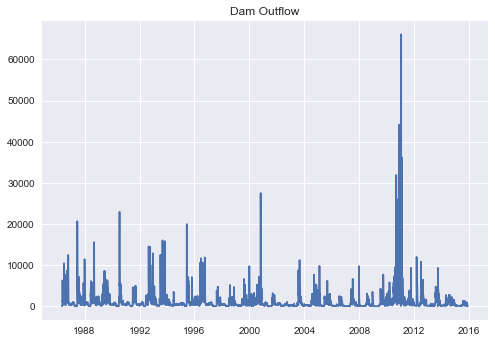

In [20]:
dam_node = network[406000]
plt.plot(dt_index, dam_node._outflow) # climate_data
plt.title("Dam Outflow")
# plt.show()

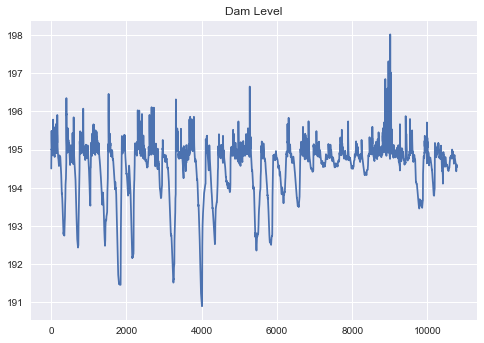

In [21]:
plt.plot(dam_node._level)
plt.title("Dam Level")
plt.show()

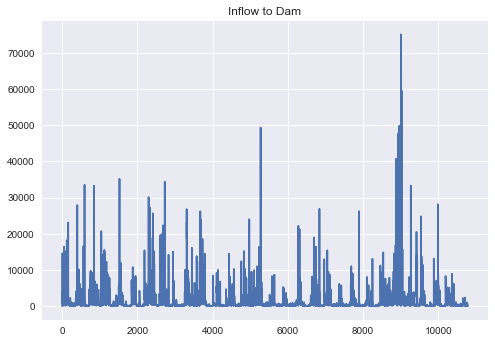

In [22]:
inflows = dam_node._inflow
plt.plot(inflows)
plt.title("Inflow to Dam")
plt.show()

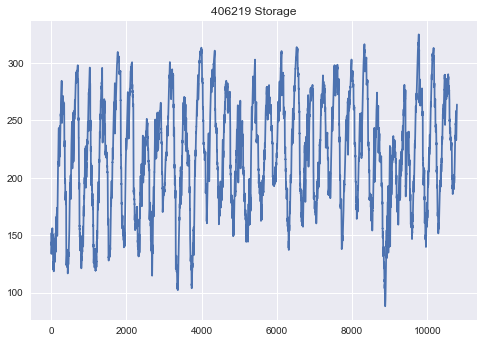

In [23]:
plt.plot(network[406219]._storage)
plt.title("406219 Storage")
plt.show()

In [39]:
from scipy import optimize
from sklearn.metrics import r2_score, mean_squared_error


level_store = []
met_score = []
score = 1e6

def obj_func(x_val, net, climate_data, ext_data, hist_levels):
    
    d, d2, e, f, scoef, alpha, a, b, f2, flow_mod, flow_mod2 = x_val
    
    # e = 1.0  # set `e` as constant as we're feeding in ET data
    
    net.reset()
    network = net.network
    
    before_lake_epp = network[406219]
    before_lake_epp.set_calib_params((d, d2, e, f), scoef, alpha, a, b, flow_mod)
    
    dam_node = network[406000]

#     system_outlets = {k: node for k, node in network.items() if node.next_node is None}
#     timesteps = len(climate_data)
#     for ts_idx in xrange(timesteps):
#         for outlet, node in system_outlets.items():
#             node.run(ts_idx, climate_data, ext_data)
#         # End for
#     # End for

    timesteps = len(climate_data)
    for ts_idx in xrange(timesteps):
        if ts_idx == 6450:
            # change f (to f2) based on time step to adjust for temporal scaling anonmaly
            # before_lake_epp.set_calib_params((d, d2, e, f2), scoef, alpha, a, b, flow_mod)
            before_lake_epp.f = f2
            before_lake_epp.flow_mod = flow_mod2
        elif ts_idx == 8800:
            before_lake_epp.f = f
            before_lake_epp.flow_mod = flow_mod
        # End if
        
        dam_node.run(ts_idx, climate_data, ext_data)
    # End for

    # metric_mse = mean_squared_error(hist_levels, dam_node._level)
    # metric_rmse = np.sqrt(metric_mse)
    # metric_r2 = r2_score(hist_levels, dam_node._level, sample_weight=None, multioutput='uniform_average')
    metric_mash = np.sum((hist_levels - dam_node._level)**2) / np.sum((hist_levels - np.mean(hist_levels))**2)
    
    metric = metric_mash
    
    global score
    global met_score
    if metric < score:
        global level_store
        level_store.append(dam_node._level[:])
        score = metric
    # End if
    met_score.append(score)
    
    return metric
# End obj_func()
    

def calib(x):

    d = (150.0, 550.0)
    d2 = (1.5, 20.0)
    e = (0.8, 1.1)
    f = (0.2, 1.3)
    scoef = (0.0, 3.0)
    alpha = (0.1, 0.9)
    a = (1.0, 100.0)
    b = (0.01, 2.0)
    f2 = (0.2, 1.3)
    flow_mod = (1.0, 3.0)
    flow_mod2 = (1.0, 3.0)
    
    bnds = [d, d2, e, f, scoef, alpha, a, b, f2, flow_mod, flow_mod2]
    
    res = optimize.minimize(obj_func, x, method='L-BFGS-B', bounds=bnds, 
                            args=(net, climate_data, ext_data, hist_levels, ),)
    return res
# End calib()

# initial node vals
# d, d2, e, f, scoef, alpha, a, b, f2, flow_mod, flow_mod2
x_0 = [150, 2.0, 1.0, 0.78, 2.5, 0.5, 54.352, 0.05, 0.9, 2.2, 2.8]
res = calib(x_0)

In [40]:
res

      fun: 0.046108202093330858
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.49242596e-04,  -1.37361192e-02,   2.40614313e-02,
        -1.60805576e-01,   0.00000000e+00,  -8.30981249e-02,
        -9.08439990e-06,  -1.61776161e-01,   4.75224540e-02,
         2.16984833e-02,   4.57072366e-03])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1332
      nit: 19
   status: 2
  success: False
        x: array([  1.50000008e+02,   1.93527350e+00,   9.96911849e-01,
         6.93918950e-01,   2.50000000e+00,   5.37040011e-01,
         5.43522059e+01,   1.47401182e-02,   8.66705447e-01,
         1.99562954e+00,   2.77111369e+00])

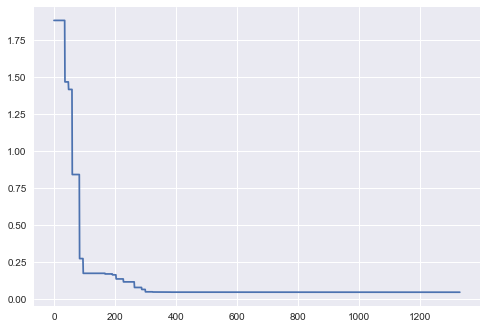

In [41]:
plt.plot(met_score)

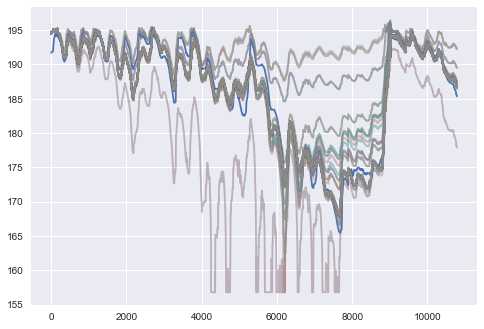

In [42]:
# %matplotlib notebook

# plot calibration attempts against historical level
plt.plot(hist_levels)
for i in level_store:
    plt.plot(i, alpha=0.2)

plt.show()

In [43]:
dt_index[8500]

Timestamp('2009-08-22 00:00:00')

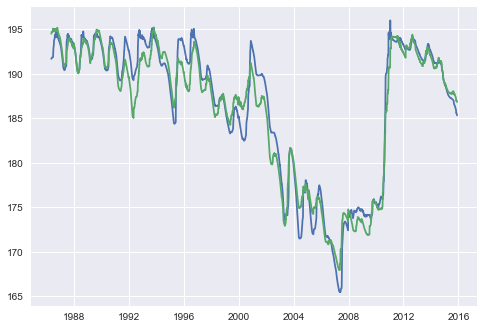

In [44]:
dam_node = net.network[406000]

plt.figure()
plt.plot(dt_index, hist_levels)
plt.plot(dt_index, level_store[-1])
# plt.plot(climate_data['406219_rain'])
# plt.plot(dam_node._level)
plt.show()

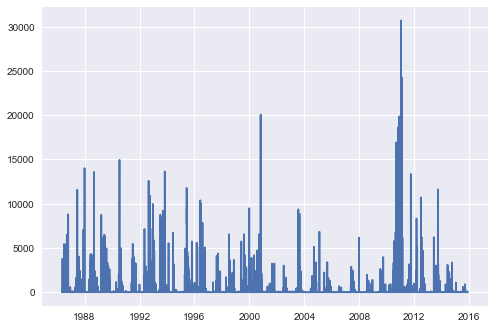

In [30]:
plt.plot(dt_index, net.network[406219]._outflow)

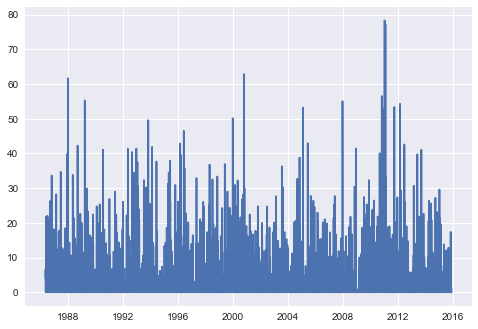

In [31]:
plt.plot(dt_index, climate_data['406219_rain'])
# plt.axhline(np.median(climate_data))

In [32]:
len(climate_data)

10787

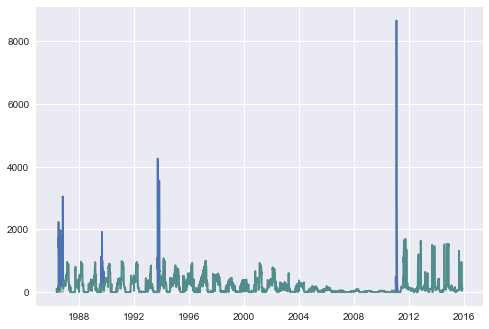

In [33]:
plt.plot(dt_index, dam_node._outflow, alpha=1.0)
plt.plot(dt_index, ext_data['406000_irrig'], alpha=0.5)

In [34]:
net.network[406219].d, net.network[406219].d2, net.network[406219].e, net.network[406219].f

(150.00020332051992,
 2.0079609046471703,
 1.0019563126377302,
 0.7885415432550662)

In [35]:
net.network[406219].storage_coef

2.5

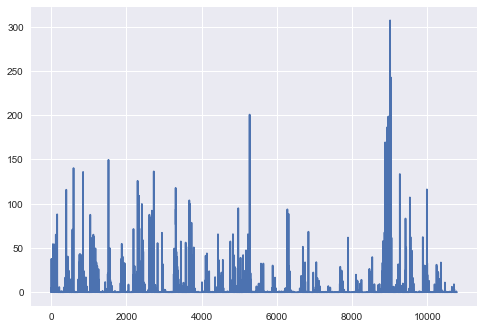

In [36]:
plt.plot(np.array(net.network[406219]._outflow) / 100.0)

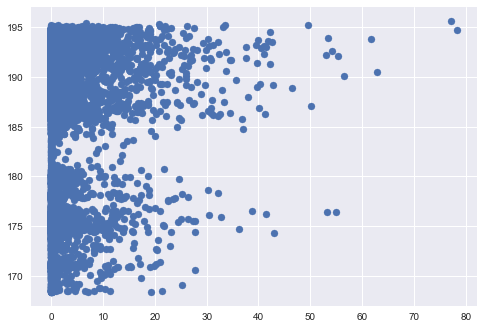

In [37]:
plt.scatter(climate_data['406219_rain'], level_store[-1])

In [38]:
# ext_data

node type ruleset

Node types:

* 1 = Top node - a node with parent node(s)
* 2 = Dam
* 3 = Member node - a node with parent node(s)
* 4 = end node

```
if node type is not 2:
    run IHACRES
    
if node type is 3:
    run routing
    update state
    
if node type is 2:
    run dam
    update state

if node type is 4:
    run routing

if node_type is not 2 and formula type is > 0:
    run level  # only the node below the dam and dam itself has a formula type > 0
```

The above workflow can be simplified using node type information

```
if node_type is not DamNode:
    run cmd  # each node is responsible for maintaining state
    
if node is below the dam or the last node:
    run routing

if node_type is DamNode:
    run dam
    
if node_type is not DamNode and formula_type is > 0:  # i.e. node is not 2 or 3
    run level
```